# TRAFFIC ACCIDENTS PREDICTION AND RISK ANALYSIS

# 📌 Introduction  

This project — **Traffic Accidents Prediction and Risk Analysis** — builds a practical pipeline to predict whether a traffic accident will occur and to produce actionable risk insights from historical accident records. The dataset (originally 840 rows, 14 columns) contains key predictors such as weather, road type, time of day, traffic density, speed limit, vehicle type, driver age/experience and alcohol involvement. The work covers data cleaning, exploratory data analysis, feature engineering, modeling with several classifiers, hyperparameter tuning, and risk profiling to support proactive road-safety decisions.

---

### 🚦 Key Steps in the Workflow:
- **Data ingestion & validation:** Loaded the dataset, checked dtypes, counts, and the target (`Accident`).
- **Missing-value handling:** Rows with missing target were removed; numeric features imputed with medians and categorical features with modes.
- **Exploratory Data Analysis (EDA):** Distribution plots, boxplots, pairwise scatter matrix, and a correlation heatmap to surface relationships and potential multicollinearity.
- **Feature engineering:** Created a composite `Risk_Score` and categorical bins — `Age_Group`, `Experience_Group`, `Speed_Category`, and `Time_Category`.
- **Preprocessing for modeling:** One-hot encoding for categorical variables, scaling numeric features with `RobustScaler`, and a stratified train-test split.
- **Modeling & evaluation:** Trained Logistic Regression, Random Forest, XGBoost, and Gradient Boosting; evaluated with cross-validation (F1), then on the test set using accuracy, precision, recall, F1, and ROC-AUC.  
- **Tuning & interpretation:** Tuned XGBoost (selected as best by F1), reported feature importances, and identified high-risk segments for operational use.

---

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset_traffic_accident.csv')
df.head()
# reading csv file

,Weather,Road_Type,Time_of_Day,Traffic_Density,Speed_Limit,Number_of_Vehicles,Driver_Alcohol,Accident_Severity,Road_Condition,Vehicle_Type,Driver_Age,Driver_Experience,Road_Light_Condition,Accident
0,Rainy,City Road,Morning,1.0,100.0,5.0,0.0,NaN,Wet,Car,51.0,48.0,Artificial Light,0.0
1,Clear,Rural Road,Night,NaN,120.0,3.0,0.0,Moderate,Wet,Truck,49.0,43.0,Artificial Light,0.0
2,Rainy,Highway,Evening,1.0,60.0,4.0,0.0,Low,Icy,Car,54.0,52.0,Artificial Light,0.0
3,Clear,City Road,Afternoon,2.0,60.0,3.0,0.0,Low,Under Construction,Bus,34.0,31.0,Daylight,0.0
4,Rainy,Highway,Morning,1.0,195.0,11.0,0.0,Low,Dry,Car,62.0,55.0,Artificial Light,1.0


## Exploring Data

In [3]:
print(f"Dataset Shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")
print(f"Number of records: {df.shape[0]}")

Dataset Shape: (840, 14)
Number of features: 14
Number of records: 840


In [6]:
df.columns
# lists column names

Index(['Weather', 'Road_Type', 'Time_of_Day', 'Traffic_Density', 'Speed_Limit',
       'Number_of_Vehicles', 'Driver_Alcohol', 'Accident_Severity',
       'Road_Condition', 'Vehicle_Type', 'Driver_Age', 'Driver_Experience',
       'Road_Light_Condition', 'Accident'],
      dtype='object')

In [3]:
df.info()
# gives info about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Weather               798 non-null    object 
 1   Road_Type             798 non-null    object 
 2   Time_of_Day           798 non-null    object 
 3   Traffic_Density       798 non-null    float64
 4   Speed_Limit           798 non-null    float64
 5   Number_of_Vehicles    798 non-null    float64
 6   Driver_Alcohol        798 non-null    float64
 7   Accident_Severity     798 non-null    object 
 8   Road_Condition        798 non-null    object 
 9   Vehicle_Type          798 non-null    object 
 10  Driver_Age            798 non-null    float64
 11  Driver_Experience     798 non-null    float64
 12  Road_Light_Condition  798 non-null    object 
 13  Accident              798 non-null    float64
dtypes: float64(7), object(7)
memory usage: 92.0+ KB


In [4]:
df.describe()
# statistical summary for numeric columns

,Traffic_Density,Speed_Limit,Number_of_Vehicles,Driver_Alcohol,Driver_Age,Driver_Experience,Accident
count,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000
mean,1.001253,71.050125,3.286967,0.160401,43.259398,38.981203,0.299499
std,0.784894,32.052458,2.017267,0.367208,15.129856,15.273201,0.458326
min,0.000000,30.000000,1.000000,0.000000,18.000000,9.000000,0.000000
25%,0.000000,50.000000,2.000000,0.000000,30.000000,26.000000,0.000000
50%,1.000000,60.000000,3.000000,0.000000,43.000000,39.000000,0.000000
75%,2.000000,80.000000,4.000000,0.000000,56.000000,52.750000,1.000000
max,2.000000,213.000000,14.000000,1.000000,69.000000,69.000000,1.000000


In [5]:
df.describe(include = 'O')
# statistical summary for categorical columns

,Weather,Road_Type,Time_of_Day,Accident_Severity,Road_Condition,Vehicle_Type,Road_Light_Condition
count,798,798,798,798,798,798,798
unique,5,4,4,3,4,4,3
top,Clear,Highway,Afternoon,Low,Dry,Car,Artificial Light
freq,334,402,272,478,400,589,402


In [8]:
print("TARGET VARIABLE: Accident")
print(df['Accident'].value_counts(dropna=False))
accident_rate = df['Accident'].mean() * 100
print(f"Accident Rate: {accident_rate:.2f}%")

TARGET VARIABLE: Accident
Accident
0.0    559
1.0    239
NaN     42
Name: count, dtype: int64
Accident Rate: 29.95%


## Data Preprocessing
### Handling Missing Values

In [9]:
mis = df.isnull().sum()
mis_percent = (mis / len(df)) * 100
info = pd.DataFrame({'Missing Count': mis, 'Missing Percentage': mis_percent})
# checking for null values

In [10]:
mis_summary = info[info['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(mis_summary)

                      Missing Count  Missing Percentage
Weather                          42                 5.0
Road_Type                        42                 5.0
Time_of_Day                      42                 5.0
Traffic_Density                  42                 5.0
Speed_Limit                      42                 5.0
Number_of_Vehicles               42                 5.0
Driver_Alcohol                   42                 5.0
Accident_Severity                42                 5.0
Road_Condition                   42                 5.0
Vehicle_Type                     42                 5.0
Driver_Age                       42                 5.0
Driver_Experience                42                 5.0
Road_Light_Condition             42                 5.0
Accident                         42                 5.0


In [11]:
df_clean = df.copy()
df_clean = df_clean.dropna(subset=['Accident'])
# makes a copy so original df remains unchanged and remove rows where target Accident is missing

In [13]:
df_clean.shape

(798, 14)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
# setting style for better visualizations

Traffic_Density - Mean: 1.01, Median: 1.00


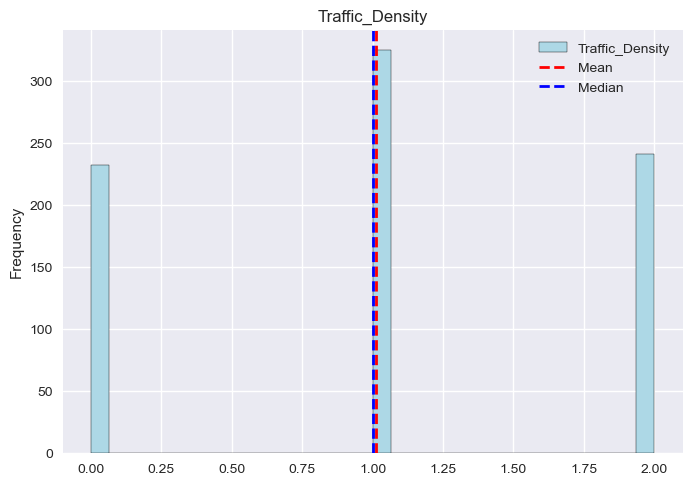

In [49]:
col = 'Traffic_Density'

print(f"{col} - Mean: {df_clean[col].mean():.2f}, Median: {df_clean[col].median():.2f}")

df_clean[col].plot(kind='hist', bins=30, title=col, color='lightblue', edgecolor='black')
plt.axvline(df_clean[col].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(df_clean[col].median(), color='blue', linestyle='--', linewidth=2, label='Median')
plt.legend()
plt.show()
# shows mean and median, useful for spotting skew
# draws histogram with 30 bins using pandas' wrapper around Matplotlib

Speed_Limit - Mean: 70.49, Median: 60.00


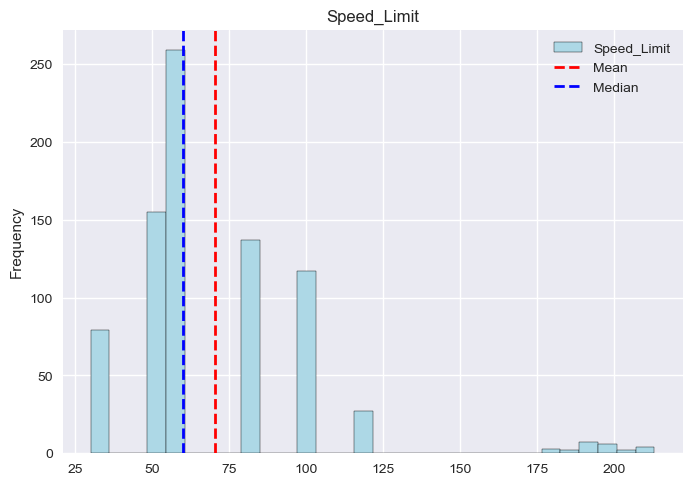

In [50]:
col = 'Speed_Limit'

print(f"{col} - Mean: {df_clean[col].mean():.2f}, Median: {df_clean[col].median():.2f}")

df_clean[col].plot(kind='hist', bins=30, title=col, color='lightblue', edgecolor='black')
plt.axvline(df_clean[col].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(df_clean[col].median(), color='blue', linestyle='--', linewidth=2, label='Median')
plt.legend()
plt.show()

Number_of_Vehicles - Mean: 3.28, Median: 3.00


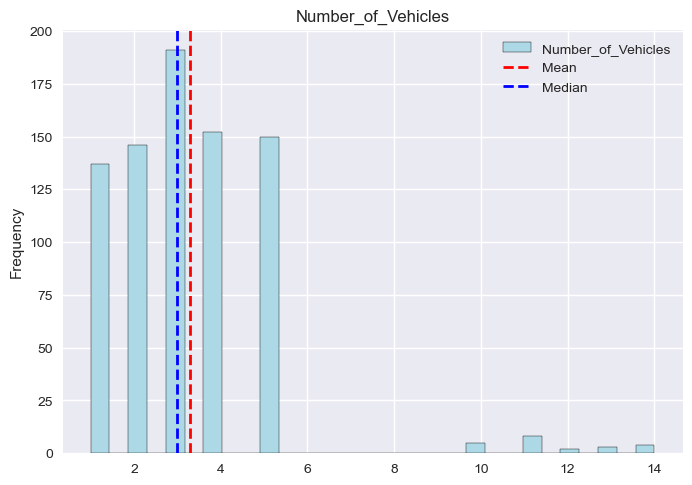

In [51]:
col = 'Number_of_Vehicles'

print(f"{col} - Mean: {df_clean[col].mean():.2f}, Median: {df_clean[col].median():.2f}")

df_clean[col].plot(kind='hist', bins=30, title=col, color='lightblue', edgecolor='black')
plt.axvline(df_clean[col].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(df_clean[col].median(), color='blue', linestyle='--', linewidth=2, label='Median')
plt.legend()
plt.show()

Driver_Alcohol - Mean: 0.15, Median: 0.00


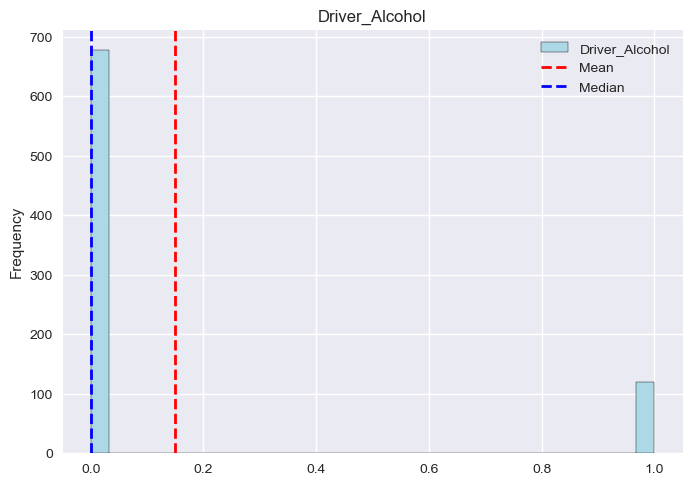

In [52]:
col = 'Driver_Alcohol'

print(f"{col} - Mean: {df_clean[col].mean():.2f}, Median: {df_clean[col].median():.2f}")

df_clean[col].plot(kind='hist', bins=30, title=col, color='lightblue', edgecolor='black')
plt.axvline(df_clean[col].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(df_clean[col].median(), color='blue', linestyle='--', linewidth=2, label='Median')
plt.legend()
plt.show()

Driver_Age - Mean: 43.47, Median: 43.00


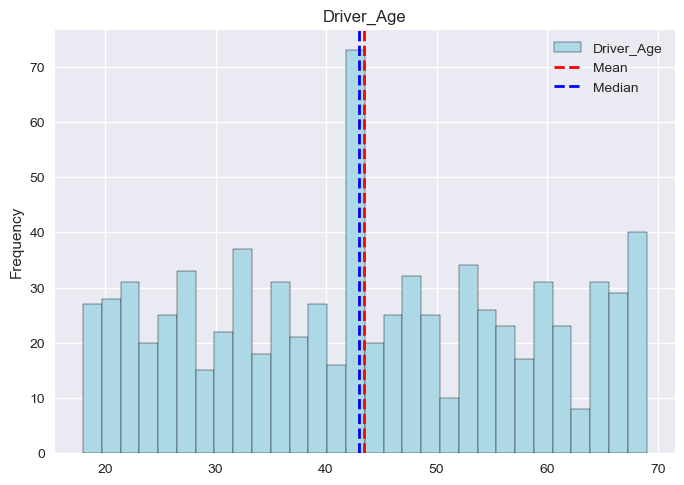

In [53]:
col = 'Driver_Age'

print(f"{col} - Mean: {df_clean[col].mean():.2f}, Median: {df_clean[col].median():.2f}")

df_clean[col].plot(kind='hist', bins=30, title=col, color='lightblue', edgecolor='black')
plt.axvline(df_clean[col].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(df_clean[col].median(), color='blue', linestyle='--', linewidth=2, label='Median')
plt.legend()
plt.show()

Driver_Experience - Mean: 39.29, Median: 40.00


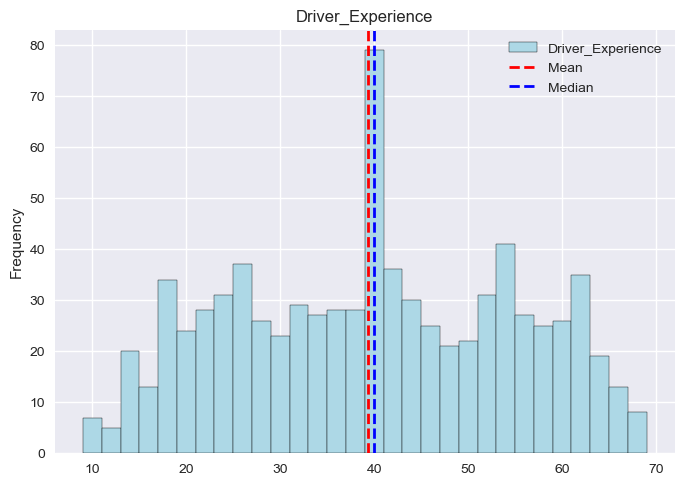

In [54]:
col = 'Driver_Experience'

print(f"{col} - Mean: {df_clean[col].mean():.2f}, Median: {df_clean[col].median():.2f}")

df_clean[col].plot(kind='hist', bins=30, title=col, color='lightblue', edgecolor='black')
plt.axvline(df_clean[col].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(df_clean[col].median(), color='blue', linestyle='--', linewidth=2, label='Median')
plt.legend()
plt.show()

In [21]:
numerical_cols = ['Traffic_Density', 'Speed_Limit', 'Number_of_Vehicles', 'Driver_Alcohol',
                  'Driver_Age', 'Driver_Experience']
# list of numeric features

In [22]:
for col in numerical_cols:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)
        print(f"Imputed {col} with median: {median_val:.2f}")
# replace NaNs with median value

Imputed Traffic_Density with median: 1.00
Imputed Speed_Limit with median: 60.00
Imputed Number_of_Vehicles with median: 3.00
Imputed Driver_Alcohol with median: 0.00
Imputed Driver_Age with median: 43.00
Imputed Driver_Experience with median: 40.00


In [26]:
cols = ['Weather', 'Road_Type', 'Time_of_Day', 'Accident_Severity', 'Road_Condition', 'Vehicle_Type', 'Road_Light_Condition']

for i in cols:
    print(f"{i} - Mode: {df[i].mode()}")
# categorical columns and thier modes

Weather - Mode: 0    Clear
Name: Weather, dtype: object
Road_Type - Mode: 0    Highway
Name: Road_Type, dtype: object
Time_of_Day - Mode: 0    Afternoon
Name: Time_of_Day, dtype: object
Accident_Severity - Mode: 0    Low
Name: Accident_Severity, dtype: object
Road_Condition - Mode: 0    Dry
Name: Road_Condition, dtype: object
Vehicle_Type - Mode: 0    Car
Name: Vehicle_Type, dtype: object
Road_Light_Condition - Mode: 0    Artificial Light
Name: Road_Light_Condition, dtype: object


In [23]:
categorical_cols = ['Weather', 'Road_Type', 'Time_of_Day', 'Accident_Severity', 'Road_Condition',
                    'Vehicle_Type', 'Road_Light_Condition']

In [24]:
for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        mode_val = df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Unknown'
        df_clean[col] = df_clean[col].fillna(mode_val)
        print(f"Imputed {col} with mode: {mode_val}")
# replaces NaNs with that mode

Imputed Weather with mode: Clear
Imputed Road_Type with mode: Highway
Imputed Time_of_Day with mode: Afternoon
Imputed Accident_Severity with mode: Low
Imputed Road_Condition with mode: Dry
Imputed Vehicle_Type with mode: Car
Imputed Road_Light_Condition with mode: Artificial Light


In [25]:
df_clean.isnull().sum()
# recheck for null values

Weather                 0
Road_Type               0
Time_of_Day             0
Traffic_Density         0
Speed_Limit             0
Number_of_Vehicles      0
Driver_Alcohol          0
Accident_Severity       0
Road_Condition          0
Vehicle_Type            0
Driver_Age              0
Driver_Experience       0
Road_Light_Condition    0
Accident                0
dtype: int64

In [28]:
print(f"Dataset shape after cleaning: {df_clean.shape}")

Dataset shape after cleaning: (798, 14)


### Explanatory Data Analysis

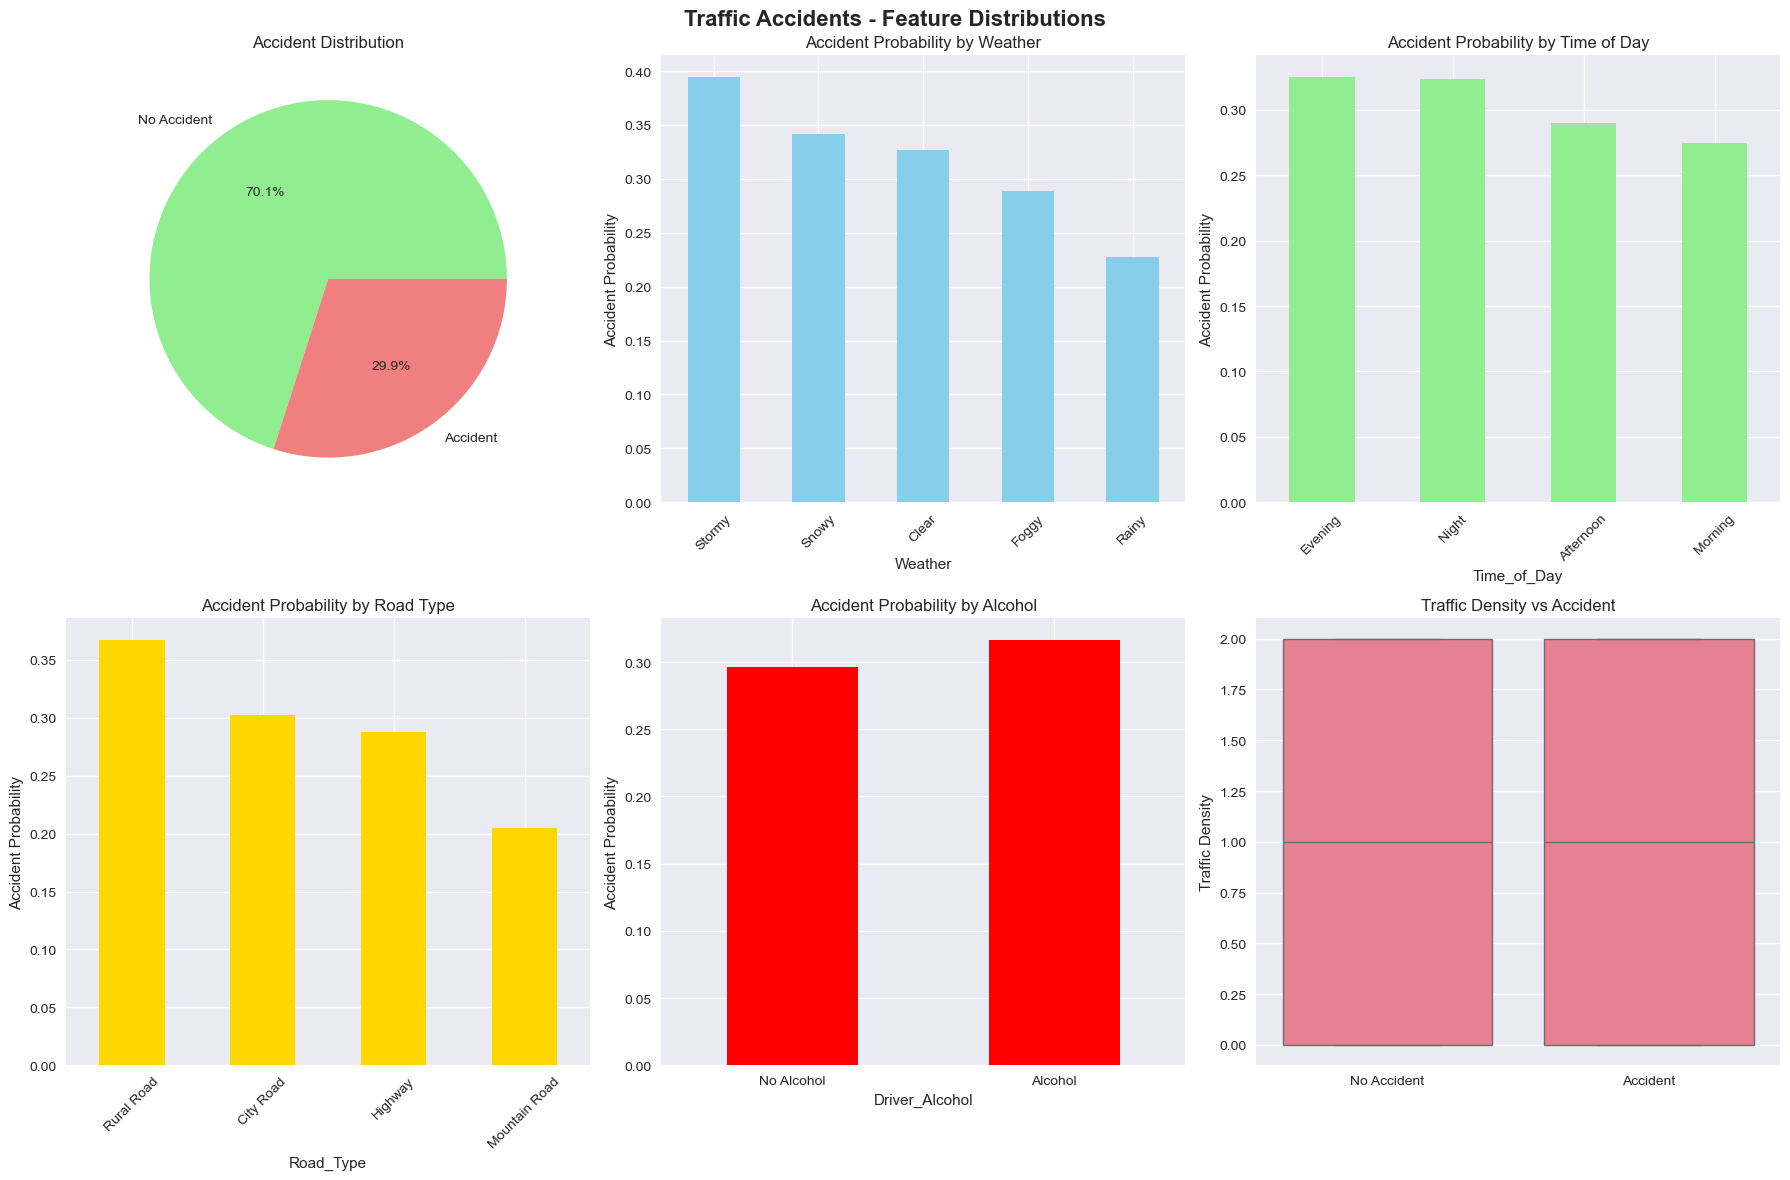

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Traffic Accidents - Feature Distributions', fontsize=16, fontweight='bold')
# suptitle sets a centered overall title

# Accident distribution
accident_counts = df_clean['Accident'].value_counts()
axes[0,0].pie(accident_counts.values, labels=['No Accident', 'Accident'], 
              autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
axes[0,0].set_title('Accident Distribution')

# Weather impact
weather_accident = df_clean.groupby('Weather')['Accident'].mean().sort_values(ascending=False)
weather_accident.plot(kind='bar', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('Accident Probability by Weather')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylabel('Accident Probability')

# Time of day impact
time_accident = df_clean.groupby('Time_of_Day')['Accident'].mean().sort_values(ascending=False)
time_accident.plot(kind='bar', ax=axes[0,2], color='lightgreen')
axes[0,2].set_title('Accident Probability by Time of Day')
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].set_ylabel('Accident Probability')

# Road type impact
road_accident = df_clean.groupby('Road_Type')['Accident'].mean().sort_values(ascending=False)
road_accident.plot(kind='bar', ax=axes[1,0], color='gold')
axes[1,0].set_title('Accident Probability by Road Type')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylabel('Accident Probability')

# Alcohol impact
alcohol_data = df_clean.groupby('Driver_Alcohol')['Accident'].mean()
if len(alcohol_data) == 2:
    alcohol_data.plot(kind='bar', ax=axes[1,1], color='red')
    axes[1,1].set_title('Accident Probability by Alcohol')
    axes[1,1].set_xticklabels(['No Alcohol', 'Alcohol'], rotation=0)
else:
    axes[1,1].text(0.5, 0.5, 'Insufficient Alcohol Data', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Alcohol Impact (No Data)')
axes[1,1].set_ylabel('Accident Probability')

# Traffic density impact
sns.boxplot(x='Accident', y='Traffic_Density', data=df_clean, ax=axes[1,2])
axes[1,2].set_title('Traffic Density vs Accident')
# Fix the x-tick labels properly
axes[1,2].set_xticklabels(['No Accident', 'Accident'])
axes[1,2].set_xlabel('')
axes[1,2].set_ylabel('Traffic Density')

plt.tight_layout()
plt.show()

In [103]:
# boxplots to visualize spread and outliers for numeric columns

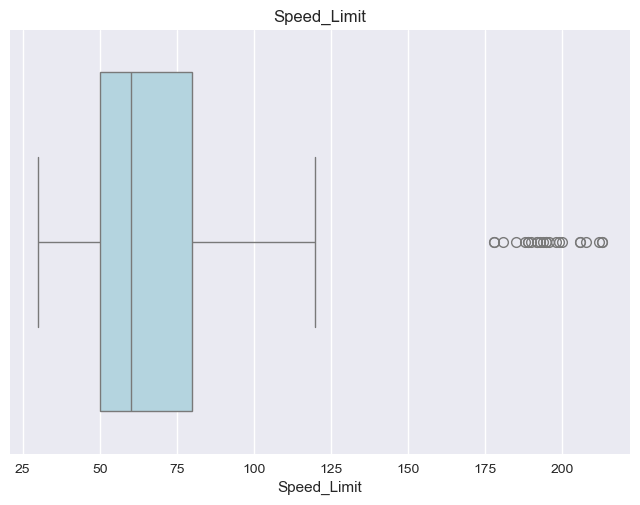

In [42]:
sns.boxplot(x=df_clean['Speed_Limit'], color='lightblue')
plt.title('Speed_Limit')
plt.show()

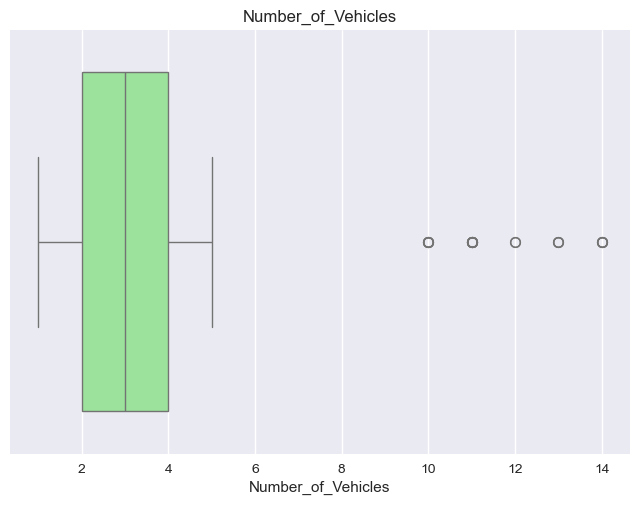

In [43]:
sns.boxplot(x=df_clean['Number_of_Vehicles'], color='lightgreen')
plt.title('Number_of_Vehicles')
plt.show()

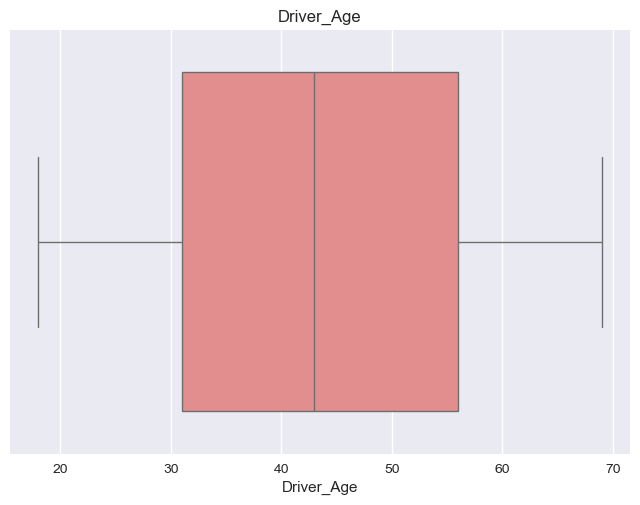

In [44]:
sns.boxplot(x=df_clean['Driver_Age'], color='lightcoral')
plt.title('Driver_Age')
plt.show()

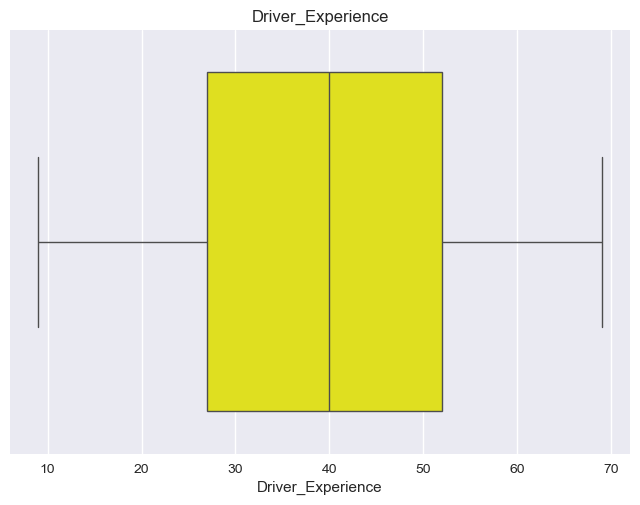

In [45]:
sns.boxplot(x=df_clean['Driver_Experience'], color='yellow')
plt.title('Driver_Experience')
plt.show()

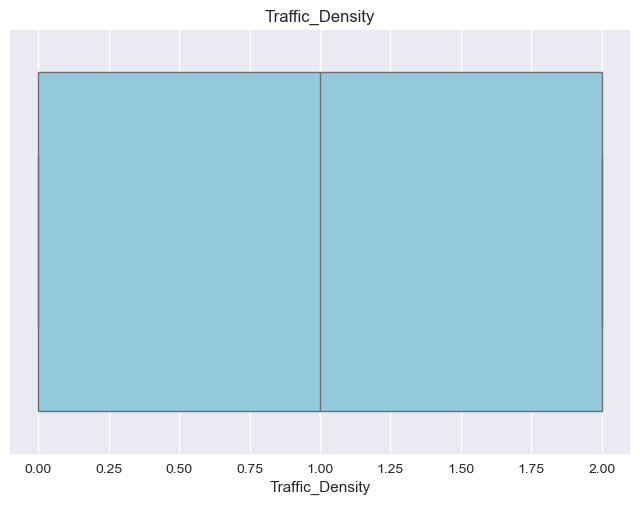

In [46]:
sns.boxplot(x=df_clean['Traffic_Density'], color='skyblue')
plt.title('Traffic_Density')
plt.show()

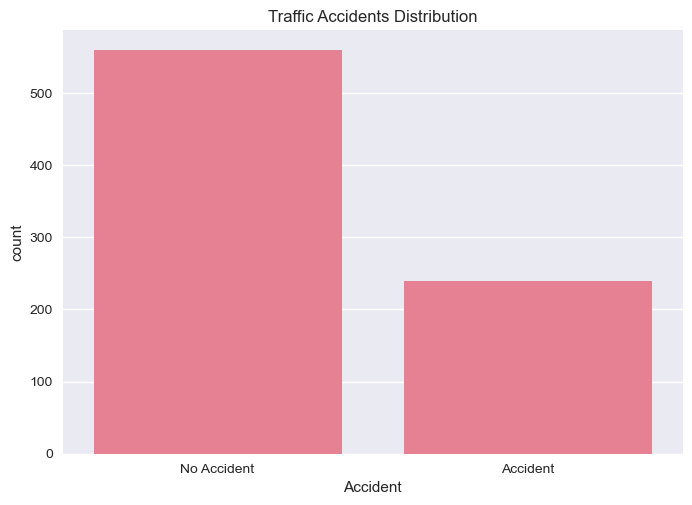

Accident Rate: 29.95%


In [47]:
# countplot shows frequency counts per Accident class
sns.countplot(x='Accident', data=df_clean)
plt.title('Traffic Accidents Distribution')
plt.xticks([0, 1], ['No Accident', 'Accident'])
plt.show()

daccident_rate = df_clean['Accident'].mean() * 100
print(f'Accident Rate: {daccident_rate:.2f}%')
# Recompute and print accident rate

In [48]:
from pandas.plotting import scatter_matrix

<Figure size 1200x1200 with 0 Axes>

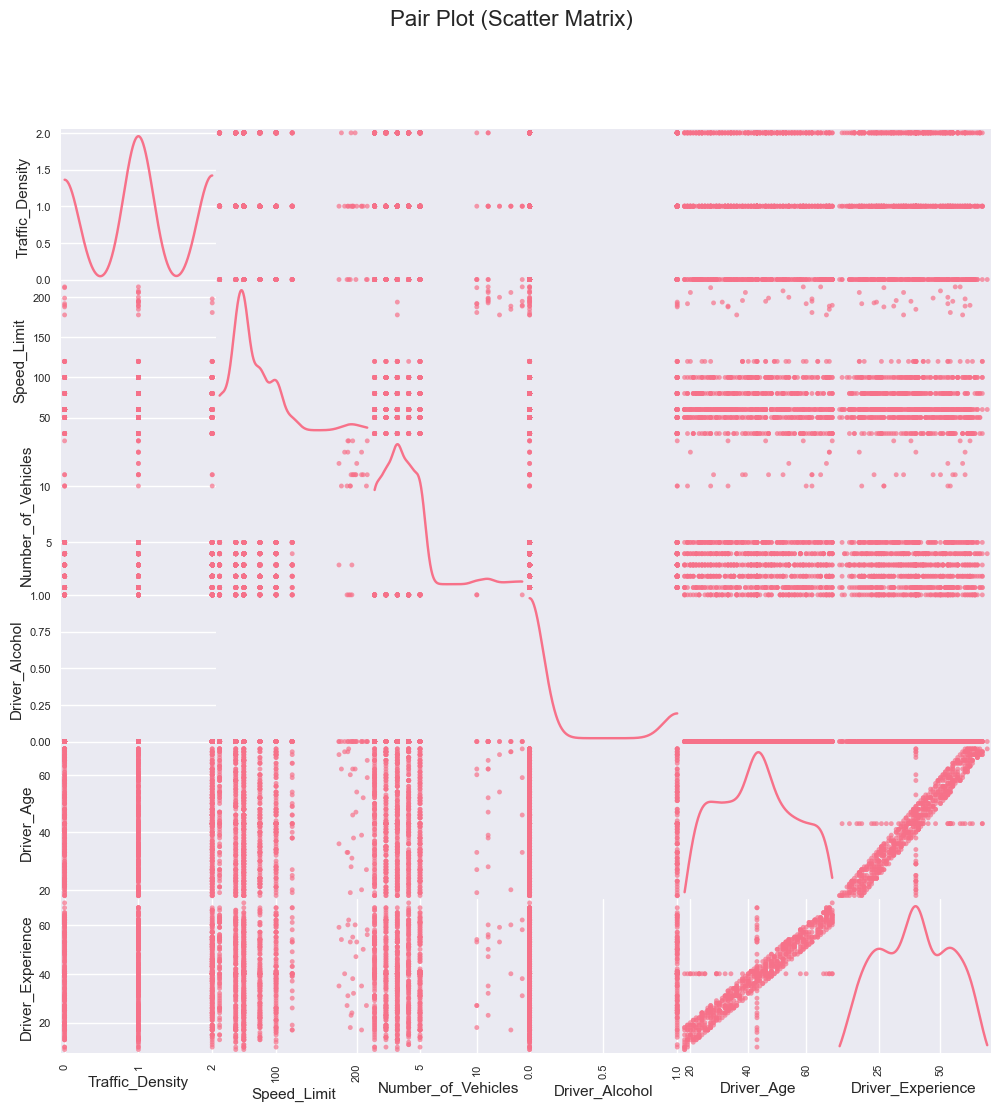

In [55]:
plt.figure(figsize=(12,12))
scatter_matrix(df_clean[numerical_cols], alpha=0.7, diagonal='kde', figsize=(12,12))
plt.suptitle("Pair Plot (Scatter Matrix)", fontsize=16)
plt.show()
# plots pairwise scatterplots for numeric variables and kernel density estimate (KDE) on diagonal

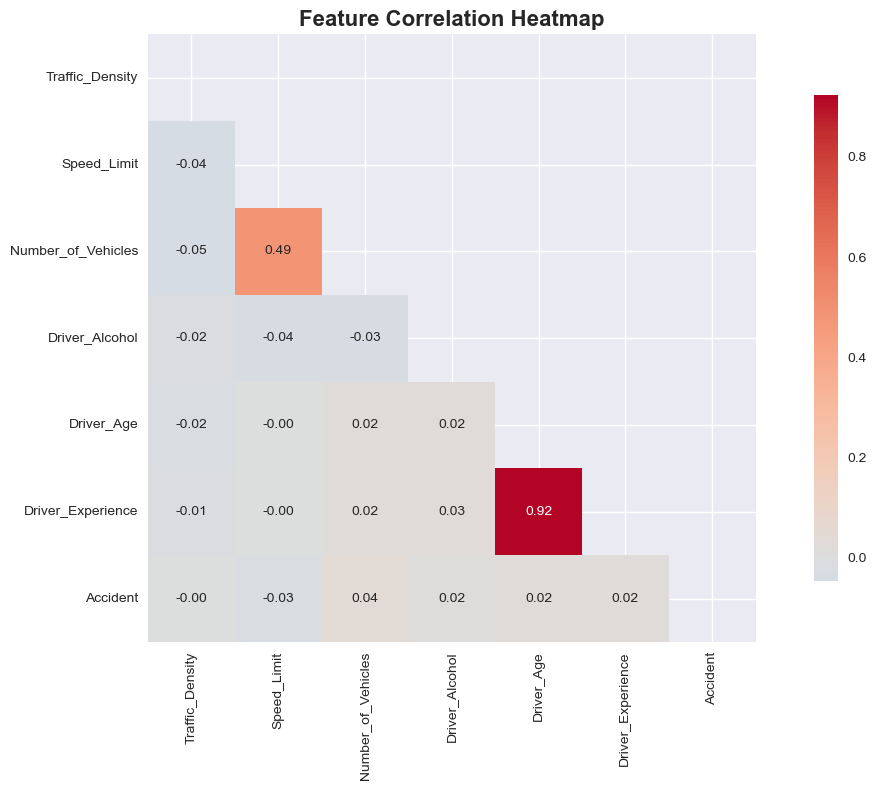

In [56]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
numerical_df = df_clean.select_dtypes(include=[np.number])
# selects numeric columns only
correlation_matrix = numerical_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
           square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
# displays correlation matrix with annotations

### Feature Engineering

In [57]:
df_engineered = df_clean.copy()

In [58]:
# new numeric column Risk score based on multiple factors
df_engineered['Risk_Score'] = (df_engineered['Traffic_Density'] * 0.3 +
                               (df_engineered['Speed_Limit'] / df_engineered['Speed_Limit'].max()) * 0.2 +
                               df_engineered['Driver_Alcohol'] * 0.3 +
                               ((100 - df_engineered['Driver_Experience']) / 100) * 0.2)

In [59]:
# Age group categorization
age_bins = [0, 25, 45, 65, 100]
age_labels = ['Young', 'Adult', 'Middle', 'Senior']
df_engineered['Age_Group'] = pd.cut(df_engineered['Driver_Age'], bins=age_bins, labels=age_labels, right=False)

In [60]:
# Experience group
exp_bins = [0, 5, 15, 30, 100]
exp_labels = ['Novice', 'Experienced', 'Veteran', 'Expert']
df_engineered['Experience_Group'] = pd.cut(df_engineered['Driver_Experience'], bins=exp_bins, labels=exp_labels, right=False)

In [61]:
# Speed limit category
speed_bins = [0, 50, 80, 120, 300]
speed_labels = ['Low', 'Medium', 'High', 'Very High']
df_engineered['Speed_Category'] = pd.cut(df_engineered['Speed_Limit'], bins=speed_bins, labels=speed_labels, right=False)

In [62]:
# Time category
def categorize_time(time_str):
    if pd.isna(time_str):
        return 'Unknown'
    if time_str in ['Morning', 'Afternoon']:
        return 'Day'
    elif time_str == 'Evening':
        return 'Evening'
    else:
        return 'Night'

df_engineered['Time_Category'] = df_engineered['Time_of_Day'].apply(categorize_time)

In [63]:
print("New features created:")
print("- Risk_Score: Combined risk factor")
print("- Age_Group: Categorical age groups")
print("- Experience_Group: Driving experience levels")
print("- Speed_Category: Speed limit categories")
print("- Time_Category: Simplified time periods")

New features created:
- Risk_Score: Combined risk factor
- Age_Group: Categorical age groups
- Experience_Group: Driving experience levels
- Speed_Category: Speed limit categories
- Time_Category: Simplified time periods


### Preparing Data for Modelling

In [64]:
feature_columns = ['Traffic_Density', 'Speed_Limit', 'Number_of_Vehicles', 'Driver_Alcohol',
                   'Driver_Age', 'Driver_Experience', 'Risk_Score']
# base numeric features for modeling

In [65]:
x = df_engineered[feature_columns].copy()
# containing numeric features

In [66]:
categorical_features = ['Weather', 'Road_Type', 'Time_of_Day', 'Road_Condition', 'Vehicle_Type',
                        'Road_Light_Condition', 'Age_Group', 'Experience_Group', 'Speed_Category', 'Time_Category']

In [67]:
for col in categorical_features:
    dummies = pd.get_dummies(df_engineered[col], prefix=col, drop_first=True)
    x = pd.concat([x, dummies], axis=1)
# creates dummy/one-hot encoded columns, drop_first=True avoids perfect multicollinearity by dropping one dummy per category

In [68]:
y = df_engineered['Accident']
# target vector

In [69]:
print(f"Final feature matrix shape: {x.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Number of features after encoding: {x.shape[1]}")

Final feature matrix shape: (798, 36)
Target variable shape: (798,)
Number of features after encoding: 36


In [70]:
from sklearn.preprocessing import RobustScaler

In [71]:
sc = RobustScaler()
numerical_features = ['Traffic_Density', 'Speed_Limit', 'Number_of_Vehicles', 'Driver_Alcohol',
                      'Driver_Age', 'Driver_Experience', 'Risk_Score']
x[numerical_features] = sc.fit_transform(x[numerical_features])
# scales numeric features using median and IQR

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
# splits data into training & testing subsets with 20% test split

In [76]:
print(f"Training set: {x_train.shape}")
print(f"Testing set: {x_test.shape}")
print(f"Positive class in training: {y_train.mean():.3f}")
print(f"Positive class in testing: {y_test.mean():.3f}")

Training set: (638, 36)
Testing set: (160, 36)
Positive class in training: 0.299
Positive class in testing: 0.300


### Model Training and Evaluation

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold

In [78]:
models = {'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, C=1.0),
          'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
          'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', n_estimators=100),
          'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)}
# Train models

In [79]:
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Cross-validation evaluation

In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [80]:
print("Cross-validation results (F1-score):")
for name, model in models.items():
    try:
        cv_scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='f1')
        cv_results[name] = cv_scores
        print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    except Exception as e:
        print(f"{name} CV failed: {e}")
        cv_results[name] = None
# computes F1 scores across the StratifiedKFold folds
# F1 is used due to class imbalance prioritizing balanced precision/recall

Cross-validation results (F1-score):
Logistic Regression: 0.0562 (+/- 0.0713)
Random Forest: 0.1630 (+/- 0.0646)
XGBoost: 0.2499 (+/- 0.1189)
Gradient Boosting: 0.2371 (+/- 0.0986)


In [81]:
results = {}
feature_importances = {}


Training Logistic Regression...

Training Random Forest...

Training XGBoost...

Training Gradient Boosting...


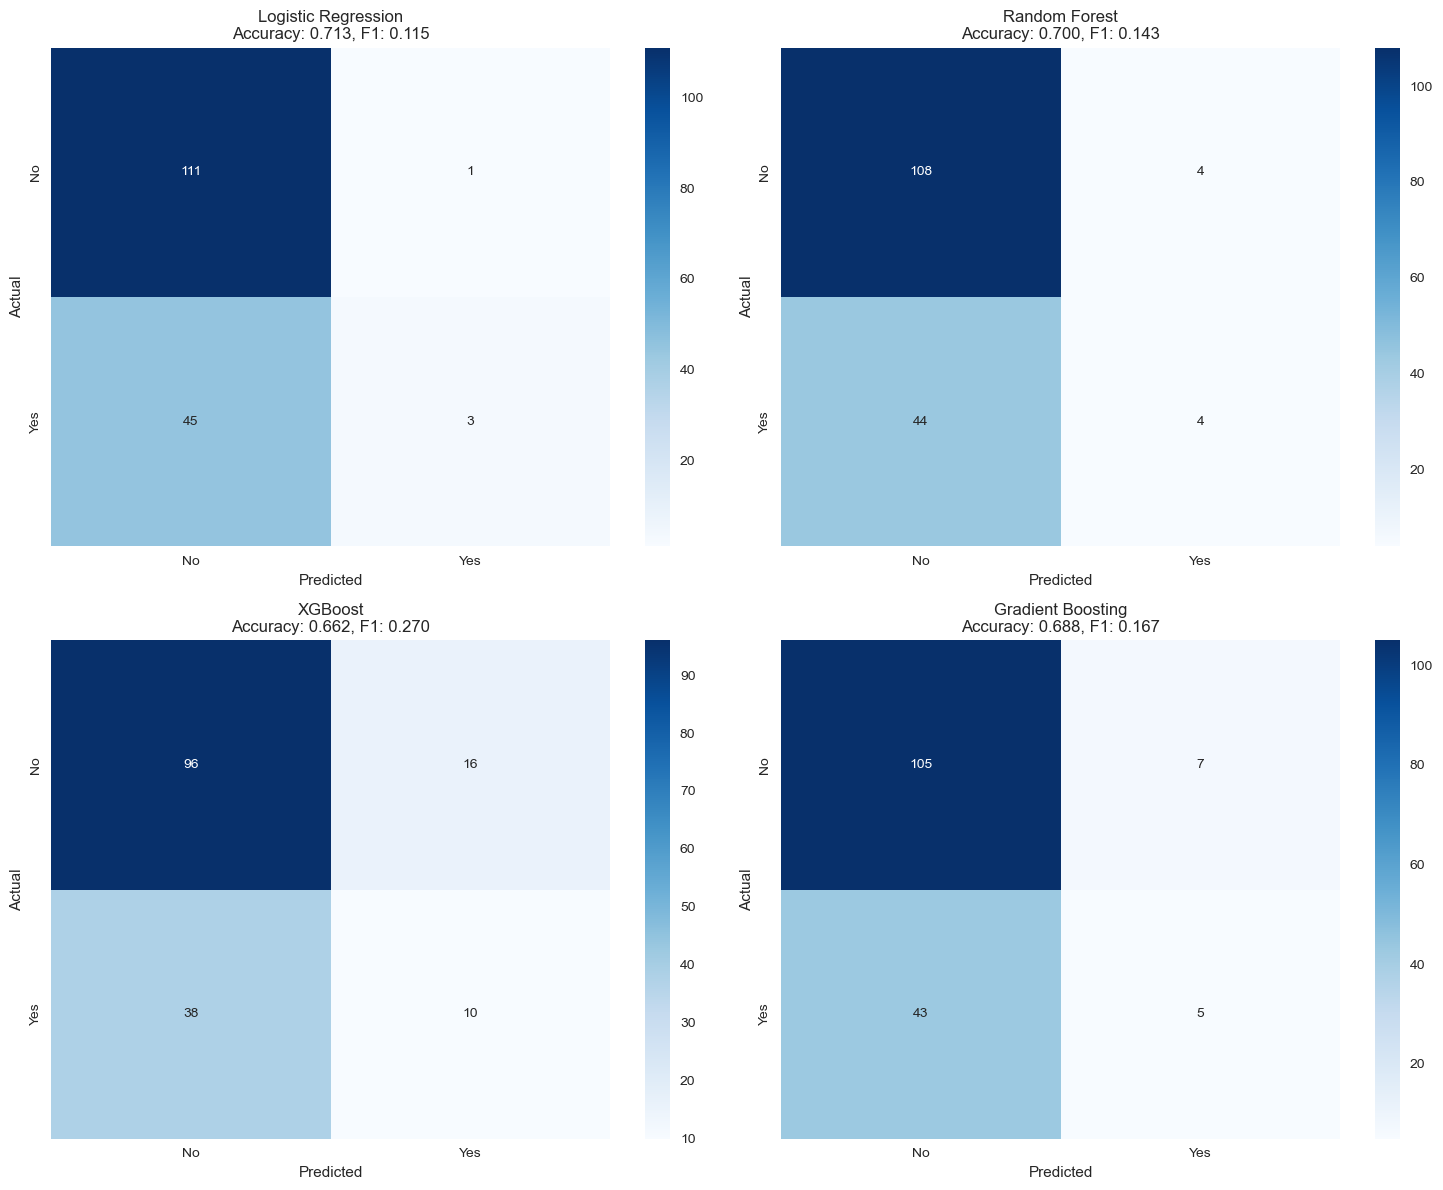

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()
# flattens the axes array to index easily
model_idx = 0
for name, model in models.items():
    try:
        print(f"\nTraining {name}...")
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        y_pred_proba = model.predict_proba(x_test)[:, 1]
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # Calculate metrices
        
        results[name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc}
        
        if hasattr(model, 'feature_importances_'):
            feature_importances[name] = model.feature_importances_
        # Storing feature importance if available
        
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[model_idx])
        axes[model_idx].set_title(f'{name}\nAccuracy: {accuracy:.3f}, F1: {f1:.3f}')
        axes[model_idx].set_xlabel('Predicted')
        axes[model_idx].set_ylabel('Actual')
        axes[model_idx].set_xticklabels(['No', 'Yes'])
        axes[model_idx].set_yticklabels(['No', 'Yes'])
        # confusion_matrix computed and plotted as a Seaborn heatmap in the corresponding subplot
        model_idx += 1
        
    except Exception as e:
        print(f"Error training {name}: {e}")
        axes[model_idx].set_visible(False)
        # Hiding the axis in case model fails
        model_idx += 1

plt.tight_layout()
plt.show()

In [85]:
if results:
    results_df = pd.DataFrame(results).T
    print("MODEL PERFORMANCE")
    print(results_df.round(4))
else:
    print("No models were successfully trained.")
    results_df = pd.DataFrame()
# Converts results dict to a DataFrame and transpose .T so rows = models and columns = metrics, then prints a rounded table

MODEL PERFORMANCE
                     accuracy  precision  recall      f1  roc_auc
Logistic Regression    0.7125     0.7500  0.0625  0.1154   0.5792
Random Forest          0.7000     0.5000  0.0833  0.1429   0.5020
XGBoost                0.6625     0.3846  0.2083  0.2703   0.4967
Gradient Boosting      0.6875     0.4167  0.1042  0.1667   0.5115


### Hyperparameter Tuning

In [89]:
best_model_name = results_df['f1'].idxmax()
print(f"Best model for tuning: {best_model_name}")
# Selecting the best model based on F1 score

Best model for tuning: XGBoost


In [90]:
if best_model_name == 'Random Forest':
    param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 15, None], 'min_samples_split': [2, 5],
                  'min_samples_leaf': [1, 2]}
    base_model = RandomForestClassifier(random_state=42)
elif best_model_name == 'XGBoost':
    param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.2], 'subsample': [0.8, 0.9]}
    base_model = XGBClassifier(random_state=42, eval_metric='logloss')
else:
    param_grid = {}
    base_model = models[best_model_name]
    print(f"Using default parameters for {best_model_name}")
    # using simple tuningfor other models

In [92]:
if param_grid:
# Performing grid search if parameters are defined
    try:
        grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
        grid_search.fit(x_train, y_train)
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
        tuned_model = grid_search.best_estimator_
    except Exception as e:
        print(f"Grid search failed: {e}")
        tuned_model = base_model
        tuned_model.fit(x_train, y_train)
else:
    tuned_model = base_model
    tuned_model.fit(x_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation score: 0.2971


In [93]:
y_pred_tuned = tuned_model.predict(x_test)
y_pred_proba_tuned = tuned_model.predict_proba(x_test)[:, 1]

final_f1 = f1_score(y_test, y_pred_tuned, zero_division=0)
final_auc = roc_auc_score(y_test, y_pred_proba_tuned)

In [94]:
print(f"\nTuned Model Performance:")
print(f"F1 Score: {final_f1:.4f}")
print(f"ROC AUC: {final_auc:.4f}")


Tuned Model Performance:
F1 Score: 0.1972
ROC AUC: 0.4794


### Analyzing Feature Importance

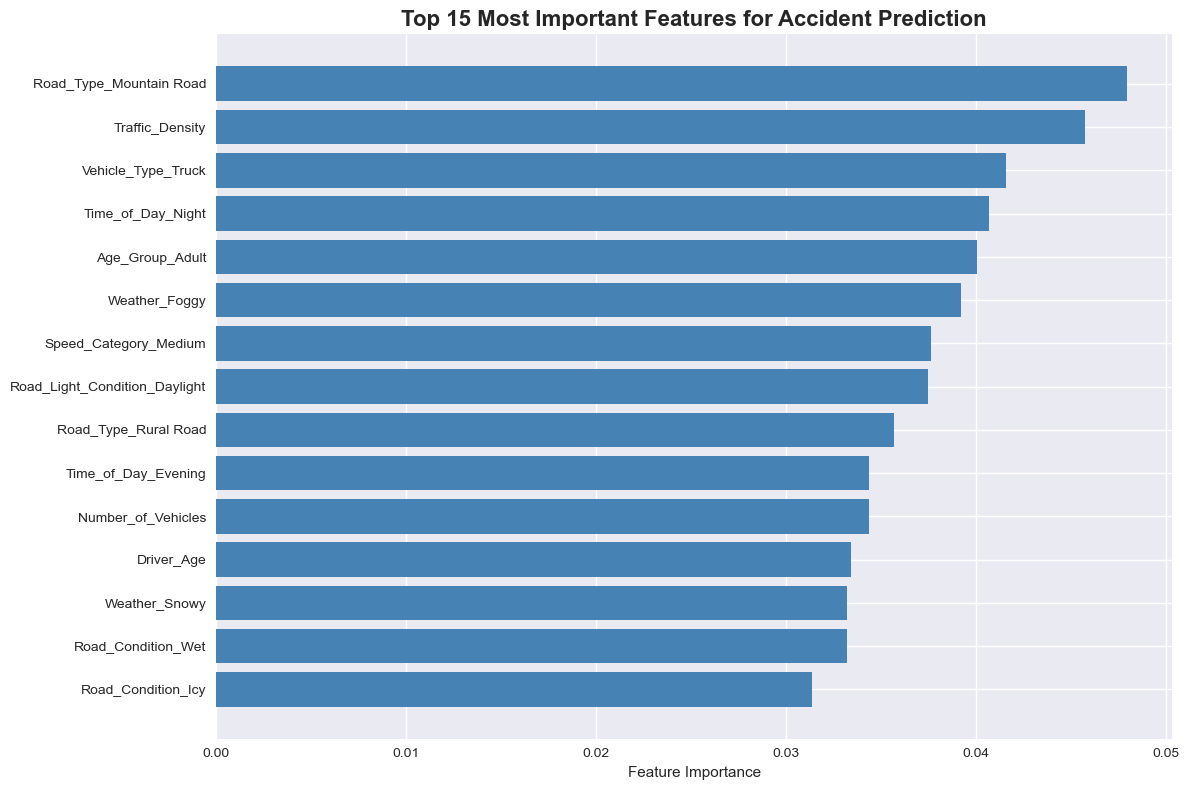

Top 10 most important features:
                      feature  importance
      Road_Type_Mountain Road    0.047924
              Traffic_Density    0.045717
           Vehicle_Type_Truck    0.041558
            Time_of_Day_Night    0.040651
              Age_Group_Adult    0.040026
                Weather_Foggy    0.039183
        Speed_Category_Medium    0.037608
Road_Light_Condition_Daylight    0.037488
         Road_Type_Rural Road    0.035695
          Time_of_Day_Evening    0.034354


In [95]:
if hasattr(tuned_model, 'feature_importances_'):
    imp_df = pd.DataFrame({'feature': x.columns,
                                  'importance': tuned_model.feature_importances_}).sort_values('importance',
                                                                                               ascending=False)
    # create DataFrame mapping feature names to importance values and sort descending
    plt.figure(figsize=(12, 8))
    top_features = imp_df.head(15)
    # Plotting top 15 features

    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_features['importance'], color='steelblue')
    plt.yticks(y_pos, top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Most Important Features for Accident Prediction', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print("Top 10 most important features:")
    print(top_features.head(10).to_string(index=False))
else:
    print("Feature importance not available for this model type.")

### Risks Analysis

In [96]:
risk_probabilities = tuned_model.predict_proba(x_test)[:, 1]
high_risk_threshold = 0.7
# to flag very likely accidents
high_risk_cases = risk_probabilities > high_risk_threshold
# boolean mask of flagged rows
high_risk_percentage = (high_risk_cases.sum() / len(risk_probabilities)) * 100

print(f"High-risk cases (probability > {high_risk_threshold}): {high_risk_percentage:.2f}%")

High-risk cases (probability > 0.7): 5.62%


In [97]:
high_risk_indices = np.where(high_risk_cases)[0]
# gets indices of flagged cases
if len(high_risk_indices) > 0:
    high_risk_features = x_test.iloc[high_risk_indices]
    print("\nCharacteristics of high-risk scenarios:")
    print(f"- Average Traffic Density: {high_risk_features['Traffic_Density'].mean():.2f}")
    print(f"- Average Speed Limit: {high_risk_features['Speed_Limit'].mean():.2f}")
    print(f"- Alcohol involvement: {(high_risk_features['Driver_Alcohol'] > 0).mean() * 100:.2f}%")
    print(f"- Average Risk Score: {high_risk_features['Risk_Score'].mean():.2f}")
else:
    print("No high-risk cases found with the current threshold.")
# Analyzing high-risk scenarios


Characteristics of high-risk scenarios:
- Average Traffic Density: 0.17
- Average Speed Limit: 0.44
- Alcohol involvement: 22.22%
- Average Risk Score: 0.39


In [98]:
print(f"Best Model: {best_model_name}")
print(f"{best_model_name} F1 Score: {final_f1:.4f}")
print(f"{best_model_name} Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"{best_model_name} Precision: {precision_score(y_test, y_pred_tuned, zero_division=0):.4f}")
print(f"{best_model_name} Recall: {recall_score(y_test, y_pred_tuned, zero_division=0):.4f}")
print(f"{best_model_name} ROC AUC: {final_auc:.4f}")

Best Model: XGBoost
XGBoost F1 Score: 0.1972
XGBoost Accuracy: 0.6438
XGBoost Precision: 0.3043
XGBoost Recall: 0.1458
XGBoost ROC AUC: 0.4794


In [101]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_tuned)
roc_auc = auc(fpr, tpr)
# ROC Curve

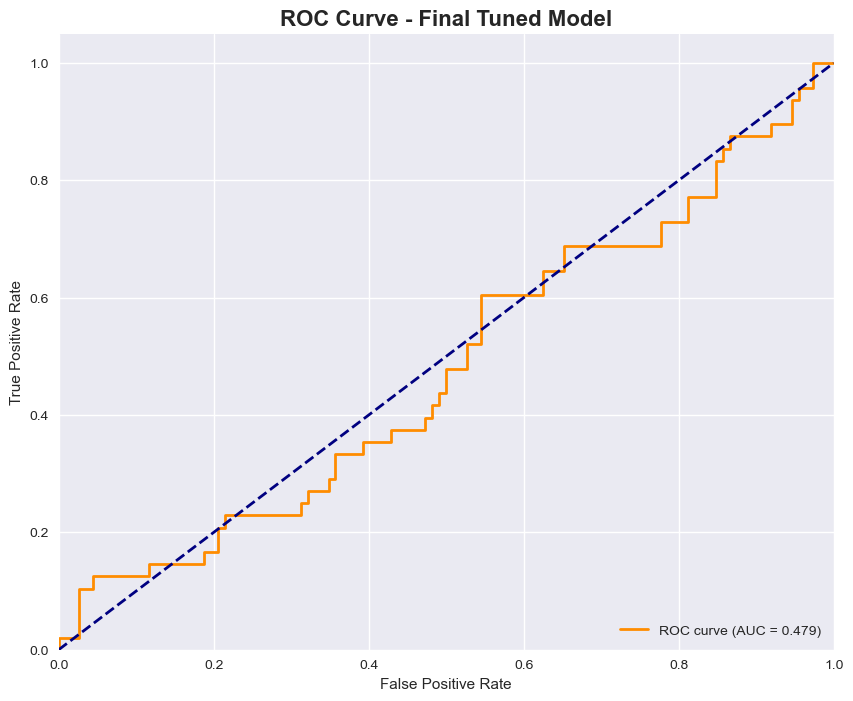

In [102]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Tuned Model', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 📌 Conclusion  

The implemented pipeline successfully demonstrates an end-to-end approach for predicting accident occurrence and deriving risk insights. However, model performance indicates substantial room for improvement before operational deployment.

---

### 🔍 Summary of Results:
- Dataset reduced to **798 records** after cleaning; class balance: **~30% accidents** (positive class).  
- Cross-validation (F1) results: Logistic Regression (≈0.056), Random Forest (≈0.163), XGBoost (≈0.250), Gradient Boosting (≈0.237).  
- **XGBoost** selected for tuning and produced the best post-tuning test performance in this run:  
  - **Final F1:** **0.1972**  
  - **ROC AUC:** **0.4794**  
  - **Accuracy:** ≈0.644  
  - Class-wise performance: strong specificity for non-accidents (precision/recall high for class 0) but **poor recall on accidents (class 1)** — the minority, operationally critical class.  
- **Feature importance highlights:** `Road_Type` (Mountain/Rural), `Traffic_Density`, `Vehicle_Type_Truck`, `Time_of_Day_Night/Evening`, `Age_Group_Adult`, and `Weather_Foggy` rank among the top contributors.  
- **Risk profiling:** ~**5.6%** of test cases were flagged as very high risk (probability > 0.7); those cases showed higher alcohol involvement and higher risk-score averages.

---

### 🚧 Interpretation & Practical Takeaways:
- The models are currently **better at identifying non-accident events** than accidents. Because accidents are the minority and the higher-cost class to miss, the low recall/F1 on class 1 means the model would miss many real incidents if deployed as-is.
- The modest ROC-AUC (~0.48) indicates the model is **not yet reliably distinguishing classes** beyond chance in this configuration.

---

### 🧭 Recommended Next Steps:
1. **Collect more data or augment features:** More examples (especially of accident cases) or richer contextual features (GPS/road geometry, temporal weather measurements, vehicle telematics) would help model learning.  
2. **Operationalization caution:** Treat current model outputs as **risk signals** to prioritize inspections/alerts rather than as definitive incident detectors until recall improves.